#### Model taken from:
- [1] Offshore Pipelaying Dynamics. Gullik Anthon Jensen 
- [2] A nonlinear PDE formulation for offshore vessel pipeline installation. Gullik A. Jensen et al 
- [3] Modeling and Control of Offshore Pipelay Operations Based on a Finite Strain Pipe Model. Gullik A. Jensen 

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.optimize import fsolve
from scipy.integrate import solve_ivp

In [2]:
import sys
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src/python_vehicle_simulator")
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src")

In [3]:
from python_vehicle_simulator.vehicles import *
from python_vehicle_simulator.lib import *
from python_vehicle_simulator.lib.gnc import ssa

In [4]:
mp = 96 #  (submerged) [kg/m]

In [5]:
node_N = 100

In [6]:
mi = [mp for i in range(node_N)] 

In [7]:
# L - the hull length
# Xg - x-center of gravity
L = 169 # [m]
Xg = 78 # [m]
mn = 123000000 # 32219000   # mass of the vessel, [kg]  Solitaire type vessel 
kp, kd=1.95e4,1.5e4

In [8]:
vessel_mass=mn/L # mass over length of vessel

In [9]:
diag_Irho = 1e2*np.array([1, 1, 2]) # [m^4]  , p.99 in [1]
 
Irho=np.diag(diag_Irho)

In [10]:
Irho

array([[100.,   0.,   0.],
       [  0., 100.,   0.],
       [  0.,   0., 200.]])

In [11]:
# Fossen book p.181
def vessel_inertia_moment(mn, Xg, L):
    r = 0.25*L
    Ir = mn*r**2
    Iz=mn*Xg**2 + Ir
    return Iz

In [12]:
vessel_inertia = vessel_inertia_moment(mn, Xg, L)

In [13]:
Irho+=vessel_inertia

In [14]:
qw = 1025 # Water density [kg/m3]
d0 = 0.761 # Outer diameter of pipe, [m]
dI= 0.69 # Inner diameter of pipe, [m]

In [15]:
Ar=math.pi*((d0/2)**2-(dI/2)**2)

In [16]:
diag_DT = 1.5*np.array([1, 1, 1]) 

In [17]:
DT=np.diag(diag_DT) # (35) in [2]

In [18]:
DT

array([[1.5, 0. , 0. ],
       [0. , 1.5, 0. ],
       [0. , 0. , 1.5]])

In [19]:
diag_CT = 1e9*np.array([1, 1, 1]) # [Nm2] p. 4721 in [3]

In [20]:
CT=np.diag(diag_CT)

In [21]:
CT

array([[1.e+09, 0.e+00, 0.e+00],
       [0.e+00, 1.e+09, 0.e+00],
       [0.e+00, 0.e+00, 1.e+09]])

In [22]:
# angles should be in radians, otherwise np.radians them  
def Re_t_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
  
    Cφ=np.matrix([[1,0,0],
                      [0,np.cos(φ),-np.sin(φ)],
                      [0,np.sin(φ),np.cos(φ)]])

    Cθ=np.matrix([[np.cos(θ),0,np.sin(θ)],
                      [0,1,0],
                      [-np.sin(θ),0,np.cos(θ)]])

    Cψ=np.matrix([[np.cos(ψ),-np.sin(ψ),0],
                      [np.sin(ψ),np.cos(ψ),0],
                      [0,0,1]])
        

    return np.array(np.dot(np.dot(Cφ,Cθ),Cψ) )

In [23]:
Re_t_([1,2,3])

array([[ 0.41198225,  0.05872664,  0.90929743],
       [-0.68124272, -0.64287284,  0.35017549],
       [ 0.60512725, -0.76371834, -0.2248451 ]])

In [24]:
rng = np.random.default_rng()

In [25]:
φ, θ, ψ = rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [26]:
def Re_t(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
    return np.apply_along_axis(Re_t_, 1, xyz)

In [27]:
Re_t_(np.array([φ[0], θ[0], ψ[0]]))

array([[ 0.90461271,  0.2975637 ,  0.30517485],
       [-0.21889315,  0.93867498, -0.26641147],
       [-0.36573438,  0.17419852,  0.91427197]])

In [28]:
startTime1 = datetime.now()
Ret=Re_t(φ,θ,ψ)
print(datetime.now() - startTime1)

0:00:00.020905


In [29]:
Ret.shape

(100, 3, 3)

In [30]:
dx,dy,dz=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [31]:
def C1(dx,dy,dz, Ret):
    B=np.vstack([np.abs(dx)*dx,(dy**2+dz**2)**0.5*dy,(dy**2+dz**2)**0.5*dz])
    ans=np.einsum('ijk,ik->ij', Ret, np.einsum('ijk,ik->ij', Ret,B.T.astype(np.float32))) 
    return ans.T

In [32]:
startTime1 = datetime.now()
C1(dx,dy,dz,Ret)
print(datetime.now() - startTime1)

0:00:00.000508


In [33]:
def fD(dx,dy,dz,DT,Ret):
    return 1/2*d0*qw*np.dot(DT, C1(dx,dy,dz,Ret))*9.81

In [34]:
fD(dx,dy,dz,DT,Ret).T

array([[-1.40797498e+03, -2.35881162e+03, -6.89681480e+03],
       [-2.32394505e+04, -1.52539337e+04,  4.37706365e+03],
       [ 1.06879160e+03,  3.24909306e+03,  7.63439268e+03],
       [ 6.75162632e+02, -3.83506278e+03,  5.86802629e+03],
       [ 5.70441950e+03,  3.69378417e+03,  6.85691929e+03],
       [ 4.84678388e+03, -1.60171509e+04,  7.40528576e+03],
       [-8.47269874e+02,  6.59410728e+03,  1.07457542e+04],
       [-3.96408563e+02, -4.72320298e+02,  2.27503781e+03],
       [ 3.82473763e+03,  1.70744071e+03, -2.76360143e+03],
       [-9.24331329e+03, -1.06818530e+04,  5.05434916e+03],
       [ 7.31412113e+03, -1.49604621e+04,  1.63192941e+04],
       [ 4.24822492e+03, -1.44062855e+03,  2.06938634e+03],
       [-8.40985991e+03,  4.22469189e+03, -1.10942688e+03],
       [ 7.68853772e+03, -1.95176387e+03, -8.07873829e+03],
       [ 1.96218477e+03,  4.47548678e+03, -2.10954257e+03],
       [-2.37151338e+03,  1.11164549e+03,  6.35660252e+03],
       [ 1.38087706e+04, -1.67738430e+04

In [35]:
startTime1 = datetime.now()
fD(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000438


In [36]:
# https://docs.scipy.org/doc/scipy-1.8.0/tutorial/integrate.html  
# 1-D Gray-Scott 

In [37]:
I=np.identity(3)

In [38]:
startTime1 = datetime.now()
np.dot(I,fD(dx,dy,dz,DT,Ret))
print(datetime.now() - startTime1)

0:00:00.000345


In [39]:
Rb_t=I # https://www.researchgate.net/profile/Thor-Fossen/publication/224560837_Modeling_and_Control_of_Offshore_Pipelay_Operations_Based_on_a_Finite_Strain_Pipe_Model/links/00b7d520e175a3f918000000/Modeling-and-Control-of-Offshore-Pipelay-Operations-Based-on-a-Finite-Strain-Pipe-Model.pdf

In [40]:
Rb_t

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [41]:
diag_DR = 1.5*np.array([1, 1, 1]) # [N m/rad]  p.4721 in [3]

In [42]:
DR=np.diag(diag_DR) 

In [43]:
Ar

0.08091250419136858

In [44]:
fg_e=np.array([[0,0,(mp-qw*Ar)*9.81] for x in range(node_N)])

In [45]:
fg_e

array([[  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.     

In [46]:
x,y,z=100*rng.standard_normal(node_N),100*rng.standard_normal(node_N),100*rng.standard_normal(node_N)

In [47]:
def Re_b(Ret):
    return Ret

In [48]:
startTime1 = datetime.now()
Re_b(Ret)
print(datetime.now() - startTime1)

0:00:00.000198


In [49]:
def phi(x, y, z, Ret,dummy):
    B=np.vstack([x,y,z])
    return np.einsum('ijk,ik->ij', Ret,B.T.astype(np.float32))

In [50]:
phi(x,y,z,Ret,None)

array([[  40.29346389,   25.06279219,  -72.1740765 ],
       [ -60.22358276,  -56.20161977,  -94.09071516],
       [  62.47284491,   63.60950698, -101.96624829],
       [  33.81459649,   27.0675192 ,   39.9473989 ],
       [  44.86389981,   -8.92839659,  -18.58878394],
       [ -93.79195986,   65.62132464,   75.4112981 ],
       [ 109.50516841,   21.73260156,  -45.61525753],
       [ -62.35303724,  143.02001718,   73.97149666],
       [  -4.45100788, -159.45468977,  186.65997136],
       [ 192.97942863,  177.31482527,  106.26879196],
       [  -9.22236726, -110.86167424,  -19.73639662],
       [ 114.29832683,  -35.80481795,  114.9789749 ],
       [ -69.2592678 ,  105.40383717, -118.29732781],
       [  26.36500482,    9.2270077 ,   14.4459728 ],
       [  52.74535896,   22.81079073,   77.4091157 ],
       [-145.61593763,   39.5082566 ,  -57.712211  ],
       [  -0.67807454,  -87.625743  ,   21.25349186],
       [  45.31084237,   87.66797002,  -26.34728786],
       [ 199.19900319,   98.

In [51]:
startTime1 = datetime.now()
phi(x,y,z,Ret,None)
print(datetime.now() - startTime1)

0:00:00.000408


In [52]:
def Π_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
    return np.array([[np.cos(θ),0,np.cos(φ)*np.sin(θ)],
                  [0,1,-np.sin(φ)],
                  [-np.sin(θ),0,np.cos(φ)*np.cos(θ)]])

In [53]:
def Π(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
  
    return np.apply_along_axis(Π_, 1, xyz)
    

In [54]:
startTime1 = datetime.now()
Π(φ,θ,ψ).shape
print(datetime.now() - startTime1)

0:00:00.005742


In [55]:
def ωe(φ,θ,ψ, dummy,dummy1):  # (100) in [2]
    A=Π(φ,θ,ψ)
    B=np.vstack([φ,θ,ψ])
    return np.einsum('ijk,ik->ij',A,B.T.astype(np.float32))

In [56]:
startTime1 = datetime.now()
ωe(φ,θ,ψ,None,None)
print(datetime.now() - startTime1)

0:00:00.005988


In [57]:
ωe(φ,θ,ψ,None,None)

array([[ 0.17690529,  0.39902648, -0.37707764],
       [-0.70550665,  0.12531064, -0.07992767],
       [ 0.77493155, -0.33071811,  0.54872474],
       [ 1.14674443,  2.73872539, -1.00270427],
       [ 1.08459073,  0.78553296, -0.50950989],
       [ 1.46274479,  0.86518295,  0.26991134],
       [-0.77677907, -0.34163499, -0.0496604 ],
       [-1.46608648,  0.51901567, -2.04497758],
       [ 0.90119193,  0.25319195, -1.15431437],
       [ 1.10351869,  0.07488243, -0.03961355],
       [ 0.67265241,  1.6813735 ,  1.40794862],
       [ 1.18531865,  0.357236  ,  0.15748599],
       [ 0.45982111, -0.19868557,  0.48182389],
       [-0.27741527,  0.30578988,  0.0379884 ],
       [-1.39381312,  0.32069095,  0.46171006],
       [-1.45047577,  0.8480546 , -0.20621813],
       [-0.01269711,  1.4745727 ,  0.21542191],
       [ 0.78014841,  0.67688451, -0.13220809],
       [-1.20332362, -0.42237943,  0.55604626],
       [ 0.14753157,  1.2200173 , -0.18002095],
       [-0.67716101,  0.24473928, -0.657

In [58]:
def d_s(f,a,b,c,Ret,omega):

    fun = f(a,b,c,Ret,omega)    
    
    def S(arr):
        a1,a2,a3=arr[0],arr[1],arr[2]
        return np.array([[0, -a3, a2 ],
                         [a3, 0, -a1],
                        [-a2, a1, 0]])
    
    K=np.apply_along_axis(S, 1, omega)

    return np.einsum('ijk,ik->ij',K,fun.astype(np.float32)).T

In [59]:
d_s(phi,x,y,z,Ret,ωe(φ,θ,ψ,None,None))

array([[-1.93487505e+01, -1.62826318e+01, -1.18202715e+00,
         1.36545674e+02, -1.91512082e+01,  4.75326322e+01,
         1.66630177e+01,  3.30865099e+02, -1.36800045e+02,
         1.49817360e+01,  1.22903282e+02,  4.67133857e+01,
        -2.72821163e+01,  4.06691292e+00,  1.42924320e+01,
        -4.07957879e+01,  5.02163241e+01, -6.24365681e+00,
        -5.76114577e+01,  1.69894993e+02,  4.76431508e+01,
        -4.57337298e+01,  1.10503580e+02, -5.64324829e+01,
         5.81121055e+01, -4.32301049e+01,  1.22914888e-01,
         2.16508379e+02,  2.64632650e+02, -2.09230033e+01,
         6.70941432e+01, -5.99088197e+01, -7.07362699e+01,
        -2.62060586e+02, -1.34122607e+02,  3.65013017e+01,
        -1.06367509e+02, -3.78425085e+01,  1.87132483e+02,
         5.15674662e+01, -6.63751534e+01, -1.08809817e+02,
         1.03152026e+01, -4.71903006e-01, -3.79069072e+01,
         4.40759029e+01, -8.64412762e+01,  3.79258178e+01,
         1.69217158e+00, -3.05335448e+01, -8.17377548e+0

In [60]:
startTime1 = datetime.now()
d_s(phi,x,y,z,Ret,ωe(φ,θ,ψ,None,None))
print(datetime.now() - startTime1)

0:00:00.014558


In [61]:
def ne(x,y,z,Ret,omega):
    A=np.multiply(np.multiply(Ret,CT),Ret)
    B=d_s(phi,x,y,z,Ret,omega).T
    return np.einsum('ijk,ik->ij', A.astype(np.float32),B-
                     np.einsum('ijk,kp->ijp',Ret.astype(np.float32), np.array([1,0,0]).reshape(3,1)).squeeze())

In [62]:
def ne_(dx,dy,dz,DT,Ret):
    return -fg_e.T-fD(dx,dy,dz,DT,Ret) #-sigma(x,y,z).T

In [63]:
ne_(dx,dy,dz,DT,Ret)

array([[ 1.40797498e+03,  2.32394505e+04, -1.06879160e+03,
        -6.75162632e+02, -5.70441950e+03, -4.84678388e+03,
         8.47269874e+02,  3.96408563e+02, -3.82473763e+03,
         9.24331329e+03, -7.31412113e+03, -4.24822492e+03,
         8.40985991e+03, -7.68853772e+03, -1.96218477e+03,
         2.37151338e+03, -1.38087706e+04, -4.69827903e+03,
         1.27741295e+04, -2.60839261e+03,  8.37472949e+03,
         9.10748251e+03,  1.61412471e+04,  7.63838308e+02,
        -1.43487018e+03,  4.51290048e+03,  7.09254032e+03,
        -2.71441590e+03,  1.56405663e+04, -3.68584353e+03,
         3.22852719e+03, -6.42022781e+03,  1.84489420e+03,
         5.46208424e+02,  5.82317542e+02, -1.06191093e+04,
        -7.39308755e+03,  4.03681537e+03,  1.88196632e+04,
        -2.85809889e+03,  2.03433909e+04,  6.43827753e+03,
         4.47689602e+02,  2.82591428e+04, -4.42759537e+03,
        -2.37456016e+03, -2.81721025e+03,  6.71353005e+03,
         4.40178257e+03, -7.94452856e+03,  1.85063519e+0

In [64]:
startTime1 = datetime.now()
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None))
print(datetime.now() - startTime1)

0:00:00.006717


In [65]:
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None))

array([[-1.65738165e+10, -1.94451864e+09, -9.42777617e+09],
       [-1.26784239e+10, -2.66434853e+10,  2.69032457e+10],
       [-7.29733806e+08,  2.01425635e+10,  4.22369339e+10],
       [ 2.16959915e+10, -1.95819508e+10, -1.01421777e+08],
       [-1.31704864e+10, -5.38162186e+08, -6.08750004e+09],
       [ 8.51977935e+09, -4.45335978e+09,  1.24869088e+09],
       [ 7.08747737e+09, -9.88909788e+09,  8.05986958e+09],
       [ 4.15611059e+07,  1.17471587e+11, -2.57872589e+09],
       [-2.58572238e+10, -3.31657349e+10, -5.50129626e+08],
       [ 1.38945813e+10, -2.51893516e+10,  3.67690691e+10],
       [ 1.11565563e+09, -3.78638981e+07, -2.08733555e+10],
       [ 1.45524611e+10, -2.51515277e+08, -1.19379783e+10],
       [-2.03833861e+10,  1.19172582e+10,  2.81664187e+10],
       [ 2.80198701e+09,  4.70715409e+09, -8.62178612e+09],
       [ 1.20242376e+10,  1.39530247e+09, -4.59249453e+08],
       [-2.47070615e+07, -1.64872466e+09,  6.28411126e+09],
       [ 4.80505733e+08,  3.14387130e+08

In [66]:
startTime1 = datetime.now()
ne_(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.003042


In [67]:
Re_b(Ret).shape

(100, 3, 3)

In [68]:
def Irho_e(Ret):
    ans= np.multiply(np.multiply(Ret,Irho),Ret) # (19) in [3] 
    return ans

In [69]:
Irho_e(Ret).shape

(100, 3, 3)

In [70]:
startTime1 = datetime.now()
Irho_e(Ret)
print(datetime.now() - startTime1)

0:00:00.000198


In [71]:
diag_CR = 1e11*np.array([1, 1, 1]) 
CR=np.diag(diag_CR)

In [72]:
CR

array([[1.e+11, 0.e+00, 0.e+00],
       [0.e+00, 1.e+11, 0.e+00],
       [0.e+00, 0.e+00, 1.e+11]])

In [73]:
def d_me(φ,θ,ψ,Ret,fun,omega):
    A=np.multiply(np.multiply(Ret,CR),Ret)
    B=d_s(fun,φ,θ,ψ,None,omega)
 
    return np.einsum('ijk,ik->ij', A,B.T.astype(np.float32)) 

In [74]:
startTime1 = datetime.now()
d_me_=d_me(φ,θ,ψ,Ret,ωe, ωe(φ,θ,ψ,None,None))
print(datetime.now() - startTime1)

0:00:00.009447


In [75]:
d_me_

array([[ 2.47143618e+02,  6.75239674e+01,  1.86223744e+02],
       [-5.36289953e+01, -1.27264248e+02,  1.04128543e+02],
       [-4.53670596e+02, -3.75759414e+02,  1.99189730e+02],
       [ 6.84180859e+02,  1.30481019e+03,  3.23778911e+01],
       [-1.83715723e+03,  1.16585724e+03,  4.17065239e+02],
       [ 2.06710598e+02, -1.56695979e+01, -3.27317880e+01],
       [-1.85641059e+01,  2.50156079e+00,  2.30139210e+02],
       [-6.06417978e-01, -3.89962448e+03,  2.12492591e+01],
       [-1.66434787e+02,  1.55730966e+02, -2.00201561e+00],
       [-1.68149229e+01,  1.04218938e+01, -7.58111236e+01],
       [ 2.21325930e+01,  1.71449600e+02, -1.58560551e+03],
       [ 5.57699371e+01, -2.85772817e+00,  2.45820082e+02],
       [-1.13712952e+01, -1.22485514e+01,  5.12033369e+00],
       [ 7.61499944e+00,  4.04474012e+00,  2.19519399e+01],
       [-3.63551875e+02, -2.88216653e+00, -9.69606627e+00],
       [ 1.87588802e-01,  5.10061542e+01,  4.30900958e+02],
       [ 1.51963865e+01,  4.51142450e+00

In [76]:
diag_DR = 1.5*np.array([1, 1, 1]) 
 
DR=np.diag(diag_DR)

In [77]:
ne_(dx,dy,dz,DT,Ret)

array([[ 1.40797498e+03,  2.32394505e+04, -1.06879160e+03,
        -6.75162632e+02, -5.70441950e+03, -4.84678388e+03,
         8.47269874e+02,  3.96408563e+02, -3.82473763e+03,
         9.24331329e+03, -7.31412113e+03, -4.24822492e+03,
         8.40985991e+03, -7.68853772e+03, -1.96218477e+03,
         2.37151338e+03, -1.38087706e+04, -4.69827903e+03,
         1.27741295e+04, -2.60839261e+03,  8.37472949e+03,
         9.10748251e+03,  1.61412471e+04,  7.63838308e+02,
        -1.43487018e+03,  4.51290048e+03,  7.09254032e+03,
        -2.71441590e+03,  1.56405663e+04, -3.68584353e+03,
         3.22852719e+03, -6.42022781e+03,  1.84489420e+03,
         5.46208424e+02,  5.82317542e+02, -1.06191093e+04,
        -7.39308755e+03,  4.03681537e+03,  1.88196632e+04,
        -2.85809889e+03,  2.03433909e+04,  6.43827753e+03,
         4.47689602e+02,  2.82591428e+04, -4.42759537e+03,
        -2.37456016e+03, -2.81721025e+03,  6.71353005e+03,
         4.40178257e+03, -7.94452856e+03,  1.85063519e+0

### Vessel

In [78]:
class VesselSemisub: # Semisub model from Fossen
    
    def __init__(self):
        
        MRB = 1.0e10 * np.array(
            [
                [0.0027, 0, 0, 0, -0.0530, 0],
                [0, 0.0027, 0, 0.0530, 0, -0.0014],
                [0, 0, 0.0027, 0, 0.0014, 0],
                [0, 0.0530, 0, 3.4775, 0, -0.0265],
                [-0.0530, 0, 0.0014, 0, 3.8150, 0],
                [0, -0.0014, 0, -0.0265, 0, 3.7192],
            ],
            float,
        )

        MA = 1.0e10 * np.array(
            [
                [0.0017, 0, 0, 0, -0.0255, 0],
                [0, 0.0042, 0, 0.0365, 0, 0],
                [0, 0, 0.0021, 0, 0, 0],
                [0, 0.0365, 0, 1.3416, 0, 0],
                [-0.0255, 0, 0, 0, 2.2267, 0],
                [0, 0, 0, 0, 0, 3.2049],
            ],
            float,
        )

        self.D = 1.0e09 * np.array(
            [
                [0.0004, 0, 0, 0, -0.0085, 0],
                [0, 0.0003, 0, 0.0067, 0, -0.0002],
                [0, 0, 0.0034, 0, 0.0017, 0],
                [0, 0.0067, 0, 4.8841, 0, -0.0034],
                [-0.0085, 0, 0.0017, 0, 7.1383, 0],
                [0, -0.0002, 0, -0.0034, 0, 0.8656],
            ],
            float,
        )

        self.G = 1.0e10 * np.diag([0.0, 0.0, 0.0006, 1.4296, 2.6212, 0.0])
        self.M = MRB + MA

    def eq_left(self,η, dη):
        return (np.matmul(self.D, dη) + np.dot(self.G,η))
        
    def tau(self,η, dη, ddη):
        return (np.matmul(self.M,ddη) + np.matmul(self.D, dη) + np.dot(self.G,η))

In [79]:
V=VesselSemisub()

In [80]:
η=np.array([0.1,0.3,0.4,0.5,0.6,0.7])
dη=np.array([0,0,0,0,0,0])
ddη=np.array([0,0,0,0,0,0])

In [81]:
tau_force = V.tau(η,dη, ddη)

In [82]:
tau_force

array([0.00000e+00, 0.00000e+00, 2.40000e+06, 7.14800e+09, 1.57272e+10,
       0.00000e+00])

In [83]:
wave_coef=1

In [84]:
def Fx(x,dx, z,dz, t, kp, kd, x_ref = 0, dx_ref=0, z_ref = 0, dz_ref=0):
    return -kp*(x-x_ref) - kd*(dx-dx_ref)-kp*(z-z_ref) - kd*(dz-dz_ref)

In [85]:
Hs = 2.5 # significant wave height in m

In [86]:
def wave_force(Hs,d0,qw, Cd=1.2):
    g=9.81 
    return 0.5 * qw * g * Hs**2 * d0 * Cd

In [87]:
wave_force(Hs,d0,qw, Cd=1.2)

28695.1696875

In [88]:

def tau(η, dη, wave_coef, kp, kd,time, Hs=2.5, Tp=10, x_ref = 0, dx_ref=0, z_ref = 0, dz_ref=0):
    x,y,z,φ,θ,ψ=η
    dx,dy,dz,dφ,dθ,dψ=dη
    F=(np.array([-Fx(x,dx,z,dz,time, kp, kd, x_ref, dx_ref, z_ref, dz_ref),0,0])
       +wave_coef*np.array([0,0,wave_force(Hs,d0,qw)])*np.sin(2*np.pi/Tp*time+1)
      ).T
    ans=np.concatenate( [F,[0,0,0]], axis=0)
    return ans

In [89]:
tau(η, dη, wave_coef, kp, kd,3)

array([9750.        ,    0.        , 7283.67179881,    0.        ,
          0.        ,    0.        ])

### Static solution

In [90]:
def catenary(x,Ws,Fh):
    return (Fh/Ws)*(np.cosh(x*Ws/Fh)-1)

In [91]:
pipe_weight_per_unit_length = mi #  (submerged) [kg/m]  # 113.07 - not submerged

In [92]:
Fx_0=82945396

In [93]:
Ws = np.array(pipe_weight_per_unit_length)*9.81 # [N/m]
h=700

In [94]:
S=math.sqrt(h*(2*Fx_0/Ws[0] -h))
horizontal_length=(Fx_0/Ws[0] -h)*np.log((S+Fx_0/Ws[0])/(Fx_0/Ws[0]-h))

In [95]:
Ws

array([941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76])

In [96]:
delta_x=horizontal_length/(node_N-1)

In [97]:
x0=[i*delta_x for i in range(node_N)]
z0=[]

for i in range(len(x0)):
    z0.append(catenary(x0[i],Ws[0],Fx_0))

length_p=[]
for i in range(1,len(z0)):
    length_p.append(math.sqrt((x0[i]-x0[i-1])**2+(z0[i]-z0[i-1])**2))

In [98]:
x0,z0

([0.0,
  111.6432812571881,
  223.2865625143762,
  334.92984377156426,
  446.5731250287524,
  558.2164062859405,
  669.8596875431285,
  781.5029688003167,
  893.1462500575047,
  1004.7895313146928,
  1116.432812571881,
  1228.0760938290691,
  1339.719375086257,
  1451.3626563434452,
  1563.0059376006334,
  1674.6492188578213,
  1786.2925001150095,
  1897.9357813721977,
  2009.5790626293856,
  2121.222343886574,
  2232.865625143762,
  2344.50890640095,
  2456.1521876581382,
  2567.795468915326,
  2679.438750172514,
  2791.0820314297025,
  2902.7253126868904,
  3014.3685939440784,
  3126.011875201267,
  3237.6551564584547,
  3349.2984377156426,
  3460.941718972831,
  3572.585000230019,
  3684.228281487207,
  3795.8715627443953,
  3907.5148440015832,
  4019.158125258771,
  4130.80140651596,
  4242.444687773148,
  4354.087969030335,
  4465.731250287524,
  4577.374531544712,
  4689.0178128019,
  4800.661094059088,
  4912.3043753162765,
  5023.947656573464,
  5135.590937830652,
  5247.234219

In [99]:
length_p

[111.6433036807073,
 111.64348306891513,
 111.64384184561895,
 111.64438001139536,
 111.64509756710899,
 111.64599451391271,
 111.64707085324815,
 111.64832658684412,
 111.64976171671883,
 111.65137624517828,
 111.65317017481645,
 111.65514350851534,
 111.65729624944706,
 111.65962840106947,
 111.66213996712985,
 111.66483095166471,
 111.6677013589967,
 111.67075119373881,
 111.67398046079207,
 111.67738916534293,
 111.68097731287142,
 111.68474490914146,
 111.68869196020616,
 111.69281847240849,
 111.69712445237991,
 111.70160990703683,
 111.70627484358894,
 111.71111926953009,
 111.71614319264478,
 111.72134662100636,
 111.72672956297403,
 111.73229202719808,
 111.73803402261665,
 111.74395555845597,
 111.75005664422807,
 111.75633728973988,
 111.76279750508158,
 111.76943730063387,
 111.77625668706308,
 111.78325567533035,
 111.79043427667929,
 111.79779250264413,
 111.8053303650507,
 111.8130478760082,
 111.82094504791748,
 111.8290218934688,
 111.83727842563916,
 111.8457146576949

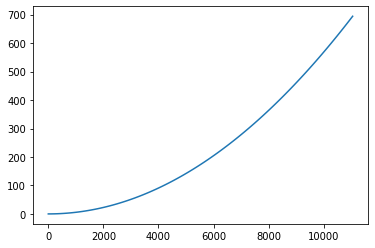

In [100]:
plt.plot(x0, z0)
plt.show()

In [101]:
rng = np.random.default_rng(seed=29)
q0=np.zeros(12*node_N)

In [102]:
for j in range(1,12):
    if j==1:  
        q0[(j-1)*node_N:j*node_N]=x0
    elif j==5:    
        q0[(j-1)*node_N:j*node_N]=z0

In [103]:
def static_func(Q):
    t=0
 
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    Ret = Re_t(φ,θ,ψ)

    
    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
    η=[x[-1],y[-1],z[-1],φ[-1],θ[-1],ψ[-1]]
    
    tau_force=np.array([-Fx_0,0,0,0,0,0])


    Z0=np.dot(Re_b(Ret),tau_force[:3])
#     Z1 = d_s(ne, x, y, z, Ret, ωe(φ,θ,ψ,None,None)).T
    Z1 = d_s(ne, x, y, z, Ret, phi(x,y,z,Ret,None)).T
    DT_0=np.zeros((3,3))
    Z2=ne_(dx,dy,dz,DT_0,Ret).T
    
    
    Z =  Z1 + Z2 + Z0
    
############################################################    
    ddx,ddy, ddz = np.linalg.solve(Ws[0]*Re_b(Ret),Z).T
############################################################    

   
    C0=np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float32)),
                        Re_b(Ret)),tau_force[3:].reshape(3,1)) 
    C3=d_me(φ,θ,ψ,Ret,  ωe,ωe(φ,θ,ψ,None,None))
    B_ =C3
    B=(B_ + C0.squeeze()
      )

    A2 = Irho_e(Ret).astype(np.float32)
    A3=Π(φ,θ,ψ).astype(np.float32)
    A=np.einsum('ijk,ikr->ijr',A2,A3)


#############################################
    ddφ,ddθ,ddψ = np.linalg.solve(A,B).T
#############################################


    ans=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)
  
    return ans 

In [104]:
q0

array([  0.        , 111.64328126, 223.28656251, ...,   0.        ,
         0.        ,   0.        ])

In [105]:
root = fsolve(static_func, q0)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [106]:
root

array([  0.        , 111.64328126, 223.28656251, ...,   0.        ,
         0.        ,   0.        ])

In [107]:
x0_,z0_=root[:node_N],root[4*node_N:5*node_N]

In [108]:
x0

[0.0,
 111.6432812571881,
 223.2865625143762,
 334.92984377156426,
 446.5731250287524,
 558.2164062859405,
 669.8596875431285,
 781.5029688003167,
 893.1462500575047,
 1004.7895313146928,
 1116.432812571881,
 1228.0760938290691,
 1339.719375086257,
 1451.3626563434452,
 1563.0059376006334,
 1674.6492188578213,
 1786.2925001150095,
 1897.9357813721977,
 2009.5790626293856,
 2121.222343886574,
 2232.865625143762,
 2344.50890640095,
 2456.1521876581382,
 2567.795468915326,
 2679.438750172514,
 2791.0820314297025,
 2902.7253126868904,
 3014.3685939440784,
 3126.011875201267,
 3237.6551564584547,
 3349.2984377156426,
 3460.941718972831,
 3572.585000230019,
 3684.228281487207,
 3795.8715627443953,
 3907.5148440015832,
 4019.158125258771,
 4130.80140651596,
 4242.444687773148,
 4354.087969030335,
 4465.731250287524,
 4577.374531544712,
 4689.0178128019,
 4800.661094059088,
 4912.3043753162765,
 5023.947656573464,
 5135.590937830652,
 5247.234219087841,
 5358.877500345028,
 5470.520781602217,


In [109]:
x0_

array([    0.        ,   111.64328126,   223.28656251,   334.92984377,
         446.57312503,   558.21640629,   669.85968754,   781.5029688 ,
         893.14625006,  1004.78953131,  1116.43281257,  1228.07609383,
        1339.71937509,  1451.36265634,  1563.0059376 ,  1674.64921886,
        1786.29250012,  1897.93578137,  2009.57906263,  2121.22234389,
        2232.86562514,  2344.5089064 ,  2456.15218766,  2567.79546892,
        2679.43875017,  2791.08203143,  2902.72531269,  3014.36859394,
        3126.0118752 ,  3237.65515646,  3349.29843772,  3460.94171897,
        3572.58500023,  3684.22828149,  3795.87156274,  3907.514844  ,
        4019.15812526,  4130.80140652,  4242.44468777,  4354.08796903,
        4465.73125029,  4577.37453154,  4689.0178128 ,  4800.66109406,
        4912.30437532,  5023.94765657,  5135.59093783,  5247.23421909,
        5358.87750035,  5470.5207816 ,  5582.16406286,  5693.80734412,
        5805.45062537,  5917.09390663,  6028.73718789,  6140.38046915,
      

In [110]:
z0

[0.0,
 0.07075924694355101,
 0.28303710149554945,
 0.6368339047222488,
 1.1321502251130366,
 1.7689868585413218,
 2.547344828264534,
 3.467225384963238,
 4.528630006682462,
 5.73156039889037,
 7.0760184944587,
 8.562006453662773,
 10.18952666416193,
 11.958581741077753,
 13.869174526915854,
 15.921308091604974,
 18.114985732516544,
 20.45021097442558,
 22.92698756958889,
 25.545319497686428,
 28.305210965821274,
 31.20666640861743,
 34.24969048810247,
 37.43428809380534,
 40.76046434271722,
 44.22822457935021,
 47.83757437567866,
 51.58851953121741,
 55.481066072943506,
 59.515220255413624,
 63.69098856070532,
 68.00837769839755,
 72.46739460568794,
 77.06804644731459,
 81.81034061559521,
 86.6942847304075,
 91.71988663928703,
 96.88715441734891,
 102.19609636736607,
 107.64672101971058,
 113.23903713243193,
 118.97305369125691,
 124.84877990958971,
 130.86622522853145,
 137.02539931689972,
 143.32631207124817,
 149.76897361584693,
 156.3533943027608,
 163.07958471182974,
 169.94755565

In [111]:
z0_

array([0.00000000e+00, 7.07592469e-02, 2.83037101e-01, 6.36833905e-01,
       1.13215023e+00, 1.76898686e+00, 2.54734483e+00, 3.46722538e+00,
       4.52863001e+00, 5.73156040e+00, 7.07601849e+00, 8.56200645e+00,
       1.01895267e+01, 1.19585817e+01, 1.38691745e+01, 1.59213081e+01,
       1.81149857e+01, 2.04502110e+01, 2.29269876e+01, 2.55453195e+01,
       2.83052110e+01, 3.12066664e+01, 3.42496905e+01, 3.74342881e+01,
       4.07604643e+01, 4.42282246e+01, 4.78375744e+01, 5.15885195e+01,
       5.54810661e+01, 5.95152203e+01, 6.36909886e+01, 6.80083777e+01,
       7.24673946e+01, 7.70680464e+01, 8.18103406e+01, 8.66942847e+01,
       9.17198866e+01, 9.68871544e+01, 1.02196096e+02, 1.07646721e+02,
       1.13239037e+02, 1.18973054e+02, 1.24848780e+02, 1.30866225e+02,
       1.37025399e+02, 1.43326312e+02, 1.49768974e+02, 1.56353394e+02,
       1.63079585e+02, 1.69947556e+02, 1.76957318e+02, 1.84108883e+02,
       1.91402263e+02, 1.98837469e+02, 2.06414513e+02, 2.14133406e+02,
      

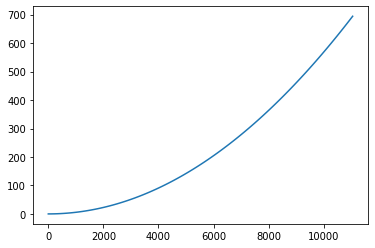

In [112]:
plt.plot(x0_, z0_)
plt.show()

In [113]:
for j in range(1,12):
    if j==1:  
        q0[(j-1)*node_N:j*node_N]=x0_
    elif j==5:    
        q0[(j-1)*node_N:j*node_N]=z0_
#     elif j==9:    
#         q0[j*node_N-1]=0.13  

In [114]:
q0

array([  0.        , 111.64328126, 223.28656251, ...,   0.        ,
         0.        ,   0.        ])

### Dynamics

In [115]:
def grayscott1d(t, Q):
#     print(t)
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    
    Ret = Re_t(φ,θ,ψ)

    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
    η=[(x0_[-1]-x[-1]),y[-1],(z0[-1]-z[-1]),φ[-1],θ[-1],ψ[-1]]
    dη=[dx[-1],dy[-1],dz[-1],dφ[-1],dθ[-1],dψ[-1]]
    
    left=V.eq_left(η,dη)
 
 
    
    # PD controller after 5 sec
    if t<5:
        ddη=np.linalg.lstsq(V.M.astype(np.float32), -left 
                            + tau(η, dη, wave_coef, 0, 0, t).astype(np.float32)
                            , rcond=None)[0]
    else:
        ddη=np.linalg.lstsq(V.M.astype(np.float32), -left.astype(np.float32) 
                            + tau(η,dη, wave_coef, kp, kd, t).astype(np.float32)
                            , rcond=None)[0]

    tau_force = V.tau(η,dη,ddη).astype(np.float32) # /1e3


    Z0=np.dot(Re_b(Ret),tau_force[:3].reshape(3,1))

#     Z1 =d_s(ne, x, y, z, Ret, ωe(φ,θ,ψ,None,None)).T
    Z1 =d_s(ne, x, y, z, Ret, phi(x,y,z,Ret,None)).T

    Z2=ne_(dx,dy,dz,DT,Ret).T
    
    Z= (Z1 + Z2 + Z0.squeeze())

############################################################    
    RRRR=Re_b(Ret)
    ddx,ddy, ddz = np.linalg.solve(np.einsum('i,ijk->ijk',[Ws[i] for i in range(node_N-1)]+[vessel_mass],RRRR),Z).T
############################################################    

    C1=np.einsum('ijk,ik->ij', Irho_e(Ret).astype(np.float32),
                                                        np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ).astype(np.float32), 
                                                                  np.array([dφ,dθ,dψ]).astype(np.float32).T))

    C2= np.cross(np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T),
                 np.einsum('ijk,ik->ij',Irho_e(Ret).astype(np.float32),
                           np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T)))

    C3=d_me(φ,θ,ψ,Ret, ωe, ωe(φ,θ,ψ,None,None)) 

    C4= np.cross(d_s(phi,x,y,z,Ret, phi(x,y,z,Ret,None)).T, ne(x,y,z,Ret, phi(x,y,z,Ret,None)))
#     C4= np.cross(d_s(phi,x,y,z,Ret, ωe(φ,θ,ψ,None,None)).T, ne(x,y,z,Ret, ωe(φ,θ,ψ,None,None)))

    
    K1=np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T).T

    C5= np.einsum('ijk,ik->ij',Ret, -np.dot(DR,K1).astype(np.float32).T)

    C0=np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float32)),
                        Re_b(Ret)),tau_force[3:].reshape(3,1)) 
    B_ =(
        -C1
        -C2
        +C3
        +C4
        +C5
    )
    B= B_ +C0.squeeze()
       

    A2 = Irho_e(Ret).astype(np.float32)
    A3=Π(φ,θ,ψ).astype(np.float32)

    A=np.einsum('ijk,ikr->ijr',A2,A3)

############################################
    ddφ,ddθ,ddψ = np.linalg.solve(A,B).T
#############################################

#     ddx[0],ddy[0],ddz[0],ddφ[0],ddθ[0],ddψ[0]=0,0,0,0,0,0
    A1111=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)

    return A1111

In [116]:
tspan = (0., 4)

In [117]:
startTime1 = datetime.now()

us=solve_ivp(grayscott1d,  tspan, q0, 
#              nfev=842
#              method='LSODA',
#              method= 'BDF'
#              vectorized=True
#              min_step=1e-6
#              rtol=1, atol=1
            )
print(datetime.now() - startTime1)

KeyboardInterrupt: 

### Results

In [ ]:
fin=us

In [ ]:
fin

In [ ]:
t=fin.t

In [ ]:
fin=fin.y.T

In [ ]:
fig=plt.figure(figsize=(13,13))
ax = fig.gca(projection='3d')

X0=fin[0,[i for i in range(0,node_N)]]
Y0=fin[0,[i for i in range(2*node_N,3*node_N)]]
Z0=fin[0,[i for i in range(4*node_N,5*node_N)]]

j=-1
X=fin[j,[i for i in range(0,node_N)]]
Y=fin[j,[i for i in range(2*node_N,3*node_N)]]
Z=fin[j,[i for i in range(4*node_N,5*node_N)]]

ax.plot(X0,Y0,Z0, color='r')
ax.plot(X,Y,Z, color='b') 
ax.view_init(-30,-30)
# ax.view_init(0,-90)
plt.show()

In [ ]:
X,Y,Z

In [ ]:
X0,Y0,Z0

In [ ]:
us=fin.T

In [ ]:
plt.plot(t,us.T[:,2],'-')
plt.xlabel('t')
plt.ylabel('x2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dx2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,2*node_N +2] ,'-')
plt.xlabel('t')
plt.ylabel('y2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,3*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dy2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,4*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('z2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,5*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dz2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,4*node_N+3] ,'-')
plt.xlabel('t')
plt.ylabel('z3')
plt.show()

In [ ]:
plt.plot(t,us.T[:,8*node_N+2],'-')
plt.xlabel('t')
plt.ylabel('θ2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,9*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dθ2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,10*node_N+2],'-')
plt.xlabel('t')
plt.ylabel('ψ2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,11*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dψ2')
plt.show()